In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import keras

In [ ]:
import tensorflow as tf

In [ ]:
class_names = ['T-shirt/top','Trousers','Pullover','Dress','Coat','Sandals','Shirt','Sneaker','Bag','Ankle boot']

In [ ]:
(x_train, y_train), (_, _) = keras.datasets.fashion_mnist.load_data()

We only hold the first three classes in the dataset.

In [ ]:
target_classes = [0, 1, 2]

In [ ]:
train_mask = np.isin(y_train, target_classes)
x_train = x_train[train_mask]

We scale the data to the range [-1, 1].

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
x_train = x_train.reshape(x_train.shape[0], -1)
x_train = scaler.fit_transform(x_train)
x_train = x_train.reshape(-1, 28, 28, 1)
x_train = x_train.astype(np.float32)


We built a generator and a discriminator and then combine them to create a GANs model.

In [ ]:
tf.random.set_seed(42)

codings_size = 30

Dense = tf.keras.layers.Dense
generator = tf.keras.Sequential([
    Dense(100, activation="relu", kernel_initializer="he_normal", input_shape=(codings_size,)),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(28 * 28, activation="tanh"),
    tf.keras.layers.Reshape([28, 28, 1])
])
discriminator = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(1, activation="sigmoid")
])
gan = tf.keras.Sequential([generator, discriminator])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)


We create a function that plots the images created by the generator and we call this function at the end of each epoch.

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="grey")
        plt.axis("off")

We define a function to train the GAN model. In each training step, it first generates fake images from random noise using the Generator. Then, it trains the Discriminator on a batch containing both the generated images and real images, with corresponding labels. After updating the Discriminator, we freeze its weights and train the Generator through the full GAN model to improve its ability to fool the Discriminator. At the end of each epoch, we use the above function to visualize the generated images.

Epoch 1/10


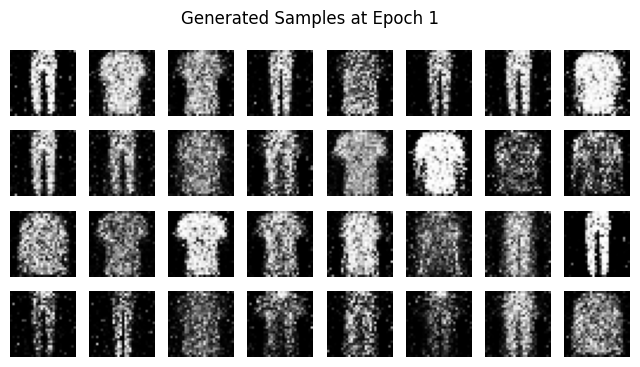

Epoch 2/10


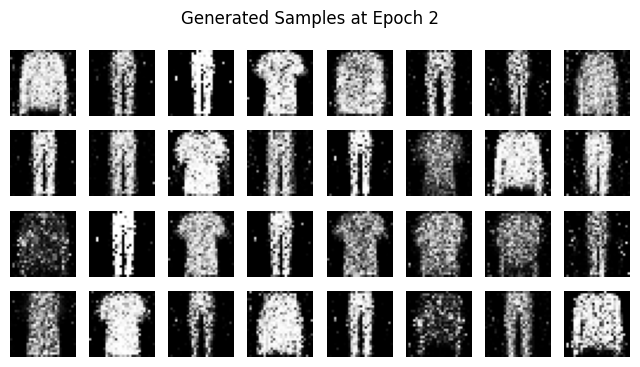

Epoch 3/10


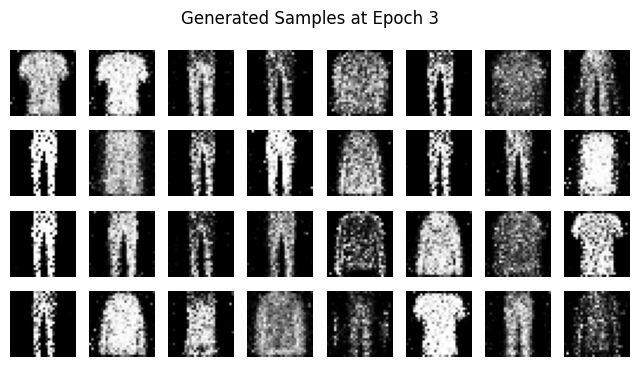

Epoch 4/10


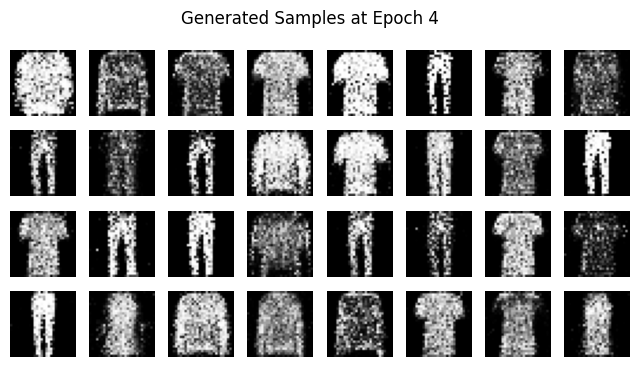

Epoch 5/10


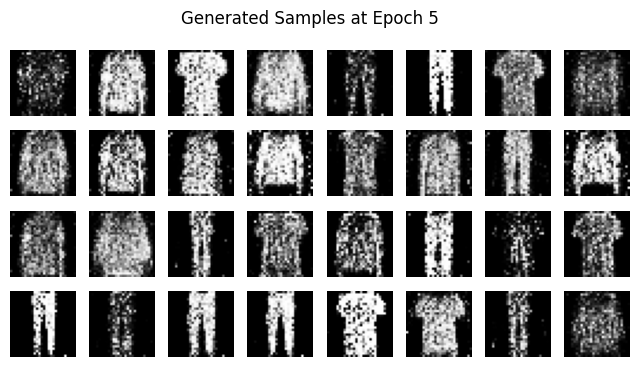

Epoch 6/10


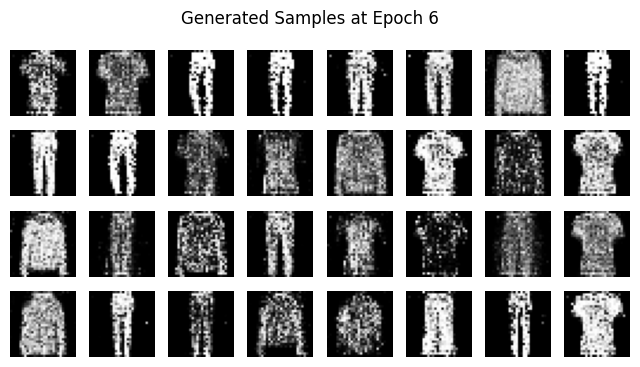

Epoch 7/10


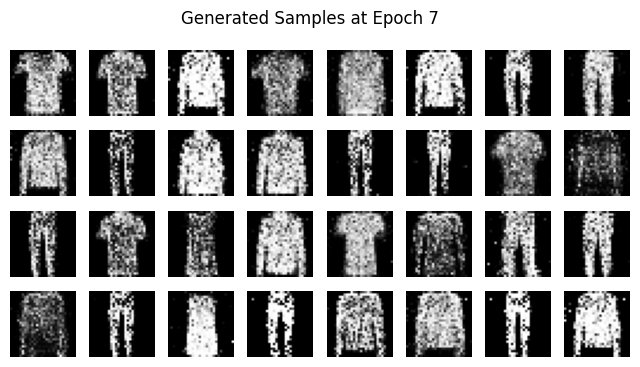

Epoch 8/10


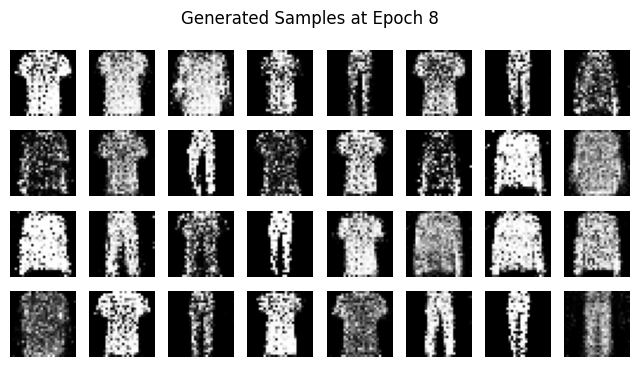

Epoch 9/10


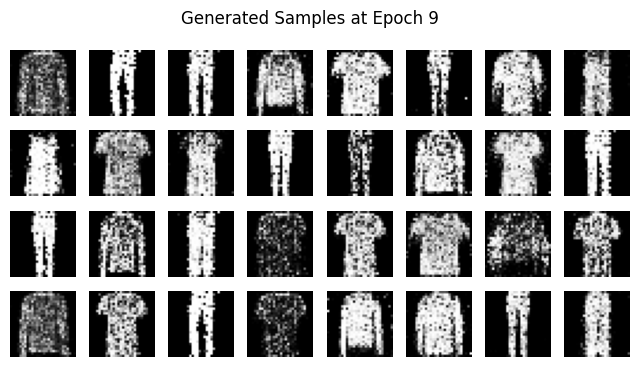

Epoch 10/10


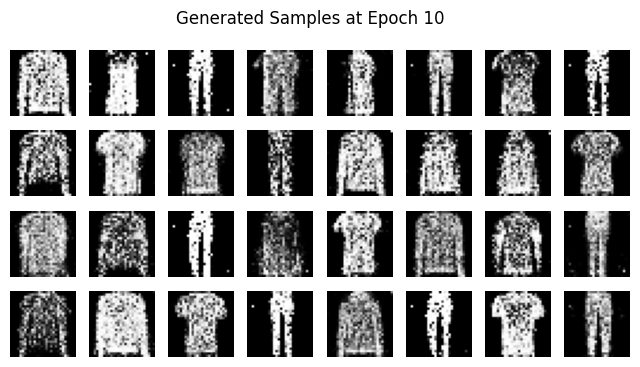

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")  # extra code
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise, training=True)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        # extra code — plot images during training
        noise = tf.random.normal(shape=[batch_size, codings_size])
        generated_images = generator(noise, training=False)
        plot_multiple_images(generated_images.numpy(), n_cols=8)
        plt.suptitle(f"Generated Samples at Epoch {epoch + 1}")
        plt.show()

train_gan(gan, dataset, batch_size, codings_size, n_epochs=10)

We can see that the generator is starting to create some good images right from the first epoch. In some epochs, like 4 and 5, the generated images seem to be worse than previous epochs. Overall, after 10 epochs the images look very similar to the real ones. If we were using more layers in the generator and discriminator and allowed the model to train for more epochs, we would probably get images that look exactly like those of the Fashion MNIST dataset.

We create a random vector and generate 32 new images using the predict method of the generator.

In [ ]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(codings)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


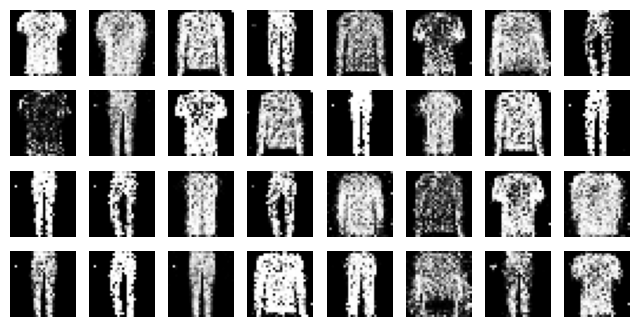

In [ ]:
plot_multiple_images(generated_images, 8)
plt.show()

Most of the images generated seem very close to the real ones.

We want to check the accuracy of the discriminator in these generated images. We make predictions using the discriminator in the generated images.

In [ ]:
pred = discriminator.predict(generated_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


We classify images as "real" if the Discriminator's prediction is above 0.5, and "fake" otherwise. Since the images are generated by the Generator, their true label is 0 (fake).


In [ ]:
predicted_classes = np.where(pred > 0.5, 1, 0).astype(np.float32)
true_labels = np.zeros((batch_size, 1), dtype=np.float32)

We use accuracy_score from sklearn to compare the predicted labels with the true labels and calculate the Discriminator's accuracy in identifying the fake images.

In [ ]:
print(accuracy_score(true_labels, predicted_classes))

0.5625


The accuracy of the discriminator is just above random guessing. This shows that the generator is producing realistic images and the discriminator finds it difficult to seperate the fake samples from the real.